In [4]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

In [7]:
dfm = pd.read_csv('../data/derivaded_3.csv',index_col=0)
print (len(dfm))
dfm.head(24)

27721


,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6,1.6
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,0.6,0.6
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,21.2,20.6,19.9,19.9,20.2,20.1,20.2,20.4,0.4,0.4
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,21.9,21.2,20.6,19.9,19.9,20.2,20.1,20.2,0.4,0.4
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,22.2,21.9,21.2,20.6,19.9,19.9,20.2,20.1,0.4,0.4
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,21.8,22.2,21.9,21.2,20.6,19.9,19.9,20.2,0.4,0.4
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,22.1,21.8,22.2,21.9,21.2,20.6,19.9,19.9,0.4,0.4
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,22.3,22.1,21.8,22.2,21.9,21.2,20.6,19.9,0.0,0.0


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [8]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [9]:
target = 'prcp_acum_24'

In [10]:
X = dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [11]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=12) 
print (len(X_train))
print (len(X_tmp))

22176
5545


<p>Separando o conjunto de testes</p>

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [13]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   22176, Training features   327
Validation instances 2773, Validation features 327
Testing instances    2772, Testing features    327


In [14]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [15]:
Z = X.copy()
Z.pop(target)
Z.pop('prcp_plus_12')
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [16]:
feature_cols

[_NumericColumn(key='prcp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='stp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='temp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dewp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericCo

In [19]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      ,activation_fn=tf.nn.sigmoid
                                      ,model_dir='/tmp/tf_model_17_1')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_log_step_count_steps': 100, '_session_config': None, '_save_summary_steps': 100, '_task_id': 0, '_model_dir': '/tmp/tf_model_17_1', '_evaluation_master': '', '_task_type': 'worker', '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_master': '', '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3c1820d2b0>, '_service': None}


In [20]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [21]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [22]:
def balancear(_X, _y):
    
    def f(x):
        if x['prcp_acum_24'] <= 0.0: 
            return 0
        elif x['prcp_acum_24'] < 50:       
            return 1
        else:
            return 2        
        
    #Balancear considerando considerando: a) sem chuva b) chuva  c) chuva extrema  
    _X.loc[:,('rain')] = _X.apply(f,axis=1) 
    
    _X_resampled, _y_resampled, idx_resampled = under.fit_sample(_X, _X['rain'])
    
    _X = pd.DataFrame(_X_resampled, columns = _X.columns)
    _y = pd.DataFrame(_y_resampled, columns =['prcp_acum_24'])
    
    for c in ['prcp_plus_12','prcp_acum_24','rain']:
        _X = _X.drop(c,1)
    
    return _X,_y

In [23]:
#X_val = X_val.drop('prcp_plus_12',1)
#X_val = X_val.drop('prcp_acum_24',1)
#X_train =  X_train.drop('prcp_plus_12',1)
#X_train =  X_train.drop('prcp_acum_24',1)

In [24]:
def f(x):
    if x['prcp_acum_24'] <= 0.0: 
        return 0
    elif x['prcp_acum_24'] < 50:       
        return 1
    else:
        return 2   

In [25]:
#A, b = balancear(X_train, y_train)

In [26]:
#A.loc[:,('prcp')] = A.loc[:,].apply(f,axis=1) 

In [27]:
#g = A.groupby('rain')
#g.count()

In [28]:
#b.groupby(pd.cut(b.values, [-50,   0,  49.99, 200])).count()

In [29]:
#len(A)

In [30]:
X_train

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
17121,0.0,917.6,918.3,917.6,21.0,16.1,21.7,16.6,21.0,16.1,...,22.4,22.3,22.5,23.5,23.0,24.1,24.4,24.7,2.6,0.0
6881,0.0,916.3,916.3,916.1,20.3,17.7,20.5,17.9,20.0,17.7,...,26.4,25.6,24.9,23.0,21.4,19.8,19.1,18.4,11.4,0.2
21250,0.4,916.3,916.3,915.5,20.2,18.5,20.4,18.9,19.7,18.4,...,18.6,18.8,19.0,19.5,19.4,20.2,22.5,23.6,2.0,0.8
26825,0.0,916.9,917.1,916.9,23.4,15.4,23.7,15.9,23.3,15.4,...,26.2,25.3,23.1,21.9,21.5,22.4,22.8,22.7,0.0,0.0
26511,0.0,920.1,920.2,920.1,23.7,15.7,23.8,16.0,23.3,15.7,...,22.7,21.9,21.6,22.3,22.8,23.1,23.4,23.4,0.0,0.0
6662,0.0,916.2,916.4,916.1,20.3,18.1,20.3,18.2,20.1,18.1,...,19.6,18.9,18.5,18.3,18.2,18.3,18.7,18.6,0.0,0.0
20087,0.0,921.8,921.9,921.5,23.8,16.7,24.0,17.2,22.3,15.9,...,27.6,27.2,27.2,26.0,24.6,24.1,23.4,22.9,0.0,0.0
21743,5.2,919.8,919.8,919.1,21.1,19.9,22.0,20.7,21.0,19.8,...,29.7,30.3,27.9,28.2,27.0,25.5,24.7,22.8,5.8,5.8
20528,0.0,919.1,919.1,919.0,28.3,13.3,29.0,14.0,27.6,11.4,...,22.2,22.4,22.7,23.3,24.0,25.0,26.3,26.5,0.0,0.0
2996,0.0,916.2,916.5,916.2,20.8,18.6,21.1,18.7,20.6,18.3,...,23.5,22.6,21.8,19.9,19.0,19.0,19.0,19.1,3.0,0.0


In [31]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(-0.8, 0.8))

_X = X_train
for c in ['prcp_plus_12','prcp_acum_24']:
    _X = _X.drop(c,1)
    
scale.fit(_X,y_train)

MinMaxScaler(copy=True, feature_range=(-0.8, 0.8))

In [27]:
#sc_A = scale.transform(_X)

In [28]:
#A = pd.DataFrame(sc_A, columns = _X.columns)

In [32]:
A, b = balancear(X_train, y_train)

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/dedeco/envs/kaggle/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [34]:
A.head(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_15,dmax_16,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24
0,0.0,917.1,917.7,917.1,28.4,19.1,29.3,20.5,27.0,17.7,...,19.9,19.9,20.5,20.2,20.2,21.1,27.3,29.7,28.9,28.5
1,0.0,918.0,918.4,918.0,29.2,15.2,30.1,15.9,28.9,14.3,...,22.2,22.6,22.9,23.6,24.0,24.7,25.5,26.3,27.3,27.6
2,0.0,920.3,920.4,920.3,23.1,18.4,23.3,18.5,22.6,18.3,...,19.7,19.2,19.0,19.0,19.1,19.1,19.4,20.0,20.4,20.5


In [34]:
A.head(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_15,dmax_16,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24
0,0.0,917.1,917.7,917.1,28.4,19.1,29.3,20.5,27.0,17.7,...,19.9,19.9,20.5,20.2,20.2,21.1,27.3,29.7,28.9,28.5
1,0.0,918.0,918.4,918.0,29.2,15.2,30.1,15.9,28.9,14.3,...,22.2,22.6,22.9,23.6,24.0,24.7,25.5,26.3,27.3,27.6
2,0.0,920.3,920.4,920.3,23.1,18.4,23.3,18.5,22.6,18.3,...,19.7,19.2,19.0,19.0,19.1,19.1,19.4,20.0,20.4,20.5


In [29]:
evaluations = []  
STEPS = 500  

for i in range(1, 100):    
    
    A, b = balancear(X_train, y_train)
    
    sc_A = scale.transform(A)
    A = pd.DataFrame(sc_A, columns = A.columns)
    
    C, d = balancear(X_val, y_val)
    
    sc_C = scale.transform(C)
    C = pd.DataFrame(sc_C, columns = C.columns)
    
    print ('treinando agora...')
    
    regressor.train(input_fn=wx_input_fn(A ,b), steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(C
                                                ,d
                                                ,num_epochs=1
                                                ,shuffle=False)))

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/dedeco/envs/kaggle/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 987.43036, step = 1
INFO:tensorflow:global_step/sec: 2.89215
INFO:tensorflow:loss = 709.0762, step = 101 (34.575 sec)
INFO:tensorflow:global_step/sec: 2.95225
INFO:tensorflow:loss = 712.6903, step = 201 (33.872 sec)
INFO:tensorflow:global_step/sec: 2.98354
INFO:tensorflow:loss = 818.46094, step = 301 (33.517 sec)
INFO:tensorflow:global_step/sec: 2.97329
INFO:tensorflow:loss = 424.55695, step = 401 (33.633 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 521.85614.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluatio

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 501 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 827.2478, step = 501
INFO:tensorflow:global_step/sec: 2.97208
INFO:tensorflow:loss = 327.3241, step = 601 (33.648 sec)
INFO:tensorflow:global_step/sec: 2.95479
INFO:tensorflow:loss = 744.9723, step = 701 (33.843 sec)
INFO:tensorflow:global_step/sec: 2.9777
INFO:tensorflow:loss = 288.4068, step = 801 (33.583 sec)
INFO:tensorflow:global_step/sec: 2.95843
INFO:tensorflow:loss = 697.4625, step = 901 (33.802 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 406.80872.
INFO:tensorflow:Calling model_fn

INFO:tensorflow:Saving checkpoints for 3500 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 338.92233.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-13:42:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-3500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-13:42:36
INFO:tensorflow:Saving dict for global step 3500: average_loss = 0.358231, global_step = 3500, loss = 135.41132
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-3500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3501 i

INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6001 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 260.26196, step = 6001
INFO:tensorflow:global_step/sec: 3.16832
INFO:tensorflow:loss = 261.88907, step = 6101 (31.564 sec)
INFO:tensorflow:global_step/sec: 3.18643
INFO:tensorflow:loss = 284.2208, step = 6201 (31.383 sec)
INFO:tensorflow:global_step/sec: 3.24247
INFO:tensorflow:loss = 243.23854, step = 6301 (30.840 sec)
INFO:tensorflow:global_step/sec: 3.24878
INFO:tensorflow:loss = 229.5156, step = 6401 (30.781 sec)
INFO:tensorflow:Saving checkpoints for 6500 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 249.56967.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-13:59:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-14:13:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-14:13:45
INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.23595512, global_step = 9000, loss = 89.19103
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9001 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 269.52383, step = 9001
INFO:tensorflow:global_step/sec: 3.44908
INFO:

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11501 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 192.51639, step = 11501
INFO:tensorflow:global_step/sec: 3.18855
INFO:tensorflow:loss = 122.97186, step = 11601 (31.363 sec)
INFO:tensorflow:global_step/sec: 3.17638
INFO:tensorflow:loss = 177.1763, step = 11701 (31.483 sec)
INFO:tensorflow:global_step/sec: 3.09791
INFO:tensorflow:loss = 110.66644, step = 11801 (32.281 sec)
INFO:tensorflow:global_step/sec: 3.23786
INFO:tensorflow:loss = 171.073, step = 11901 (30.884 sec)
INFO:tensorflow:Saving checkpoints for 12000 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 154.5962.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-14:30:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Don

INFO:tensorflow:Starting evaluation at 2018-04-19-14:44:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-14500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-14:44:05
INFO:tensorflow:Saving dict for global step 14500: average_loss = 0.24266, global_step = 14500, loss = 91.72548
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-14500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 14501 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 87.812164, step = 14501
INFO:tensorflow:global_step/sec: 3.1435
INFO:tensorflow:loss = 157.96454, step = 14601 (31.813 sec)
INFO:tensorflow:

INFO:tensorflow:Saving checkpoints for 17001 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 94.80361, step = 17001
INFO:tensorflow:global_step/sec: 3.1872
INFO:tensorflow:loss = 158.48747, step = 17101 (31.377 sec)
INFO:tensorflow:global_step/sec: 3.31745
INFO:tensorflow:loss = 113.49134, step = 17201 (30.143 sec)
INFO:tensorflow:global_step/sec: 3.30719
INFO:tensorflow:loss = 113.44876, step = 17301 (30.238 sec)
INFO:tensorflow:global_step/sec: 3.34789
INFO:tensorflow:loss = 139.11261, step = 17401 (29.869 sec)
INFO:tensorflow:Saving checkpoints for 17500 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 123.705574.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-15:00:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-17500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-15:14:14
INFO:tensorflow:Saving dict for global step 20000: average_loss = 0.22341777, global_step = 20000, loss = 84.45192
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 20001 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 146.5073, step = 20001
INFO:tensorflow:global_step/sec: 3.30653
INFO:tensorflow:loss = 88.692535, step = 20101 (30.244 sec)
INFO:tensorflow:global_step/sec: 3.32646
INFO:tensorflow:loss = 124.6472

INFO:tensorflow:loss = 166.6937, step = 22501
INFO:tensorflow:global_step/sec: 3.40272
INFO:tensorflow:loss = 83.01347, step = 22601 (29.390 sec)
INFO:tensorflow:global_step/sec: 3.47548
INFO:tensorflow:loss = 121.0729, step = 22701 (28.773 sec)
INFO:tensorflow:global_step/sec: 3.48063
INFO:tensorflow:loss = 76.56305, step = 22801 (28.731 sec)
INFO:tensorflow:global_step/sec: 3.46826
INFO:tensorflow:loss = 89.198074, step = 22901 (28.833 sec)
INFO:tensorflow:Saving checkpoints for 23000 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 55.186646.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-15:30:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-23000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-15:30:14
INFO:tensorflow:Saving dict for global 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-15:43:43
INFO:tensorflow:Saving dict for global step 25500: average_loss = 0.19222167, global_step = 25500, loss = 72.65979
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-25500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 25501 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 133.17154, step = 25501
INFO:tensorflow:global_step/sec: 3.31799
INFO:tensorflow:loss = 66.362656, step = 25601 (30.140 sec)
INFO:tensorflow:global_step/sec: 3.39442
INFO:tensorflow:loss = 97.07205, step = 25701 (29.460 sec)
INFO:tensorflow:global_step/sec: 3.44049
INFO:tensorflow:loss = 66.51836, step = 258

INFO:tensorflow:global_step/sec: 3.31857
INFO:tensorflow:loss = 41.500786, step = 28201 (30.133 sec)
INFO:tensorflow:global_step/sec: 3.33789
INFO:tensorflow:loss = 79.668945, step = 28301 (29.959 sec)
INFO:tensorflow:global_step/sec: 3.34348
INFO:tensorflow:loss = 45.880764, step = 28401 (29.909 sec)
INFO:tensorflow:Saving checkpoints for 28500 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 63.92772.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-15:59:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-28500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-15:59:54
INFO:tensorflow:Saving dict for global step 28500: average_loss = 0.22091386, global_step = 28500, loss = 83.50544
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:

INFO:tensorflow:Finished evaluation at 2018-04-19-16:13:15
INFO:tensorflow:Saving dict for global step 31000: average_loss = 0.21739094, global_step = 31000, loss = 82.173775
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-31000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 31001 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 103.24829, step = 31001
INFO:tensorflow:global_step/sec: 3.35395
INFO:tensorflow:loss = 56.013474, step = 31101 (29.817 sec)
INFO:tensorflow:global_step/sec: 3.48505
INFO:tensorflow:loss = 77.01925, step = 31201 (28.694 sec)
INFO:tensorflow:global_step/sec: 3.50238
INFO:tensorflow:loss = 33.447414, step = 31301 (28.552 sec)
INFO:tensorflow:global_step/sec: 3.47916
INFO:tensorflow:loss = 6

INFO:tensorflow:loss = 84.99213, step = 33701 (28.792 sec)
INFO:tensorflow:global_step/sec: 3.45744
INFO:tensorflow:loss = 52.742477, step = 33801 (28.924 sec)
INFO:tensorflow:global_step/sec: 3.48364
INFO:tensorflow:loss = 55.482124, step = 33901 (28.705 sec)
INFO:tensorflow:Saving checkpoints for 34000 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 26.030727.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-16:29:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-34000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-16:29:19
INFO:tensorflow:Saving dict for global step 34000: average_loss = 0.20904909, global_step = 34000, loss = 79.02055
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cr

INFO:tensorflow:Saving dict for global step 36500: average_loss = 0.18740353, global_step = 36500, loss = 70.83853
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-36500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 36501 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 47.53801, step = 36501
INFO:tensorflow:global_step/sec: 3.2947
INFO:tensorflow:loss = 65.53093, step = 36601 (30.353 sec)
INFO:tensorflow:global_step/sec: 3.35605
INFO:tensorflow:loss = 32.820587, step = 36701 (29.797 sec)
INFO:tensorflow:global_step/sec: 3.34424
INFO:tensorflow:loss = 59.525368, step = 36801 (29.902 sec)
INFO:tensorflow:global_step/sec: 3.3626
INFO:tensorflow:loss = 38.90403, step = 36901 (29.739 sec)
INFO:tensorflow:Saving check

INFO:tensorflow:global_step/sec: 3.27898
INFO:tensorflow:loss = 43.838657, step = 39301 (30.497 sec)
INFO:tensorflow:global_step/sec: 3.12057
INFO:tensorflow:loss = 32.4602, step = 39401 (32.045 sec)
INFO:tensorflow:Saving checkpoints for 39500 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 31.612026.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-16:59:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-39500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-16:59:17
INFO:tensorflow:Saving dict for global step 39500: average_loss = 0.22707756, global_step = 39500, loss = 85.83532
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized

treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-42000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 42001 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 68.38774, step = 42001
INFO:tensorflow:global_step/sec: 3.33432
INFO:tensorflow:loss = 57.631985, step = 42101 (29.992 sec)
INFO:tensorflow:global_step/sec: 3.36326
INFO:tensorflow:loss = 31.995705, step = 42201 (29.732 sec)
INFO:tensorflow:global_step/sec: 3.40759
INFO:tensorflow:loss = 51.81161, step = 42301 (29.346 sec)
INFO:tensorflow:global_step/sec: 3.49419
INFO:tensorflow:loss = 23.249432, step = 42401 (28.619 sec)
INFO:tensorflow:Saving checkpoints for 42500 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 38.456352.
INFO:tensorfl

INFO:tensorflow:global_step/sec: 3.22428
INFO:tensorflow:loss = 26.81719, step = 44901 (31.015 sec)
INFO:tensorflow:Saving checkpoints for 45000 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 24.083025.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-19-17:29:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-45000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-19-17:29:17
INFO:tensorflow:Saving dict for global step 45000: average_loss = 0.20391876, global_step = 45000, loss = 77.08129
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-45000
INFO:tensorflow:Runnin

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-47500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 47501 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:loss = 54.06225, step = 47501
INFO:tensorflow:global_step/sec: 3.28542
INFO:tensorflow:loss = 36.7389, step = 47601 (30.439 sec)
INFO:tensorflow:global_step/sec: 3.33891
INFO:tensorflow:loss = 38.73737, step = 47701 (29.950 sec)
INFO:tensorflow:global_step/sec: 3.32908
INFO:tensorflow:loss = 20.957787, step = 47801 (30.038 sec)
INFO:tensorflow:global_step/sec: 3.345
INFO:tensorflow:loss = 32.979256, step = 47901 (29.895 sec)
INFO:tensorflow:Saving checkpoints for 48000 into /tmp/tf_model_15/model.ckpt.
INFO:tensorflow:Loss for final step: 33.760998.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_f

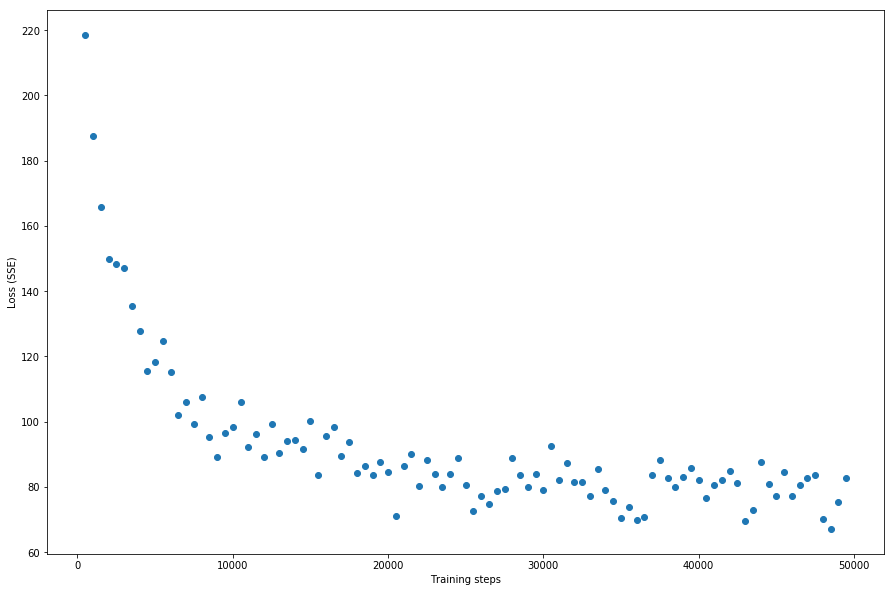

In [30]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [31]:
X_test = X_test.drop('prcp_plus_12',1)
X_test = X_test.drop('prcp_acum_24',1)

In [32]:
sc_X_test = scale.transform(X_test)
C = pd.DataFrame(sc_X_test, columns = X_test.columns)

In [33]:
C

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_15,dmax_16,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24
0,-0.800000,0.434286,0.427273,0.404494,0.060215,0.45,-0.029947,0.411834,-0.027586,0.446626,...,-0.097110,-0.106358,-2.206897e-01,-0.208092,-6.436782e-02,4.597701e-02,0.042105,0.064368,0.032370,-0.078613
1,-0.783673,-0.114286,-0.100000,-0.107865,-0.352688,0.51,-0.406417,0.430769,-0.294253,0.603681,...,-0.374566,-0.402312,-4.137931e-01,-0.420809,-4.321839e-01,-4.321839e-01,-0.435088,-0.413793,-0.411561,-0.411561
2,-0.800000,0.260571,0.254545,0.224719,-0.051613,0.18,-0.072727,0.118343,0.018391,0.250307,...,-0.365318,-0.319075,-2.850575e-01,-0.245087,-2.206897e-01,-1.931034e-01,-0.173099,-0.119540,-0.050867,-0.004624
3,-0.800000,0.086857,0.100000,0.098876,0.301075,-0.35,0.235294,-0.269822,0.349425,-0.348466,...,-0.254335,-0.198844,-1.747126e-01,-0.097110,-2.758621e-02,4.440892e-16,0.070175,0.147126,0.254335,0.337572
4,-0.800000,-0.388571,-0.390909,-0.395506,0.120430,0.50,0.064171,0.459172,0.193103,0.603681,...,-0.291329,-0.282081,-2.666667e-01,-0.217341,-1.931034e-01,-1.195402e-01,-0.079532,-0.018391,0.050867,0.152601
5,-0.783673,-0.214857,-0.209091,-0.197753,-0.060215,0.61,-0.021390,0.620118,0.018391,0.662577,...,-0.467052,-0.235838,-1.379310e-01,-0.189595,-1.011494e-01,-1.287356e-01,-0.238596,-0.137931,-0.134104,-0.087861
6,-0.800000,0.178286,0.172727,0.107865,-0.051613,0.42,0.124064,0.364497,0.027586,0.299387,...,-0.272832,-0.226590,-1.195402e-01,-0.087861,-6.436782e-02,-2.758621e-02,-0.014035,0.055172,0.124855,0.152601
7,-0.800000,0.224000,0.236364,0.233708,-0.137634,0.50,-0.218182,0.497041,-0.183908,0.574233,...,-0.254335,-0.300578,-1.287356e-01,0.383815,3.402299e-01,2.758621e-01,0.154386,0.156322,-0.004624,-0.087861
8,-0.800000,0.278857,0.272727,0.251685,-0.301075,0.13,-0.346524,0.156213,-0.239080,0.230675,...,0.439306,0.337572,4.321839e-01,0.319075,2.298851e-01,6.436782e-02,-0.070175,-0.183908,-0.263584,-0.254335
9,-0.800000,0.187429,0.190909,0.188764,0.464516,-0.27,0.474866,-0.250888,0.560920,-0.201227,...,-0.217341,-0.208092,-1.011494e-01,-0.069364,-1.839080e-02,9.195402e-02,0.154386,0.202299,0.272832,0.309827


In [34]:
pred = regressor.predict(input_fn=wx_input_fn(C,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_15/model.ckpt-49500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [35]:
predictions

array([ 0.23733084,  1.7872057 ,  0.19237183, ...,  0.05774563,
        1.7957253 , -0.01517676], dtype=float32)

In [36]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.04
The Mean Absolute Error: 8.70 
The Median Absolute Error: 0.49 


In [37]:
predictions

array([ 0.23733084,  1.7872057 ,  0.19237183, ...,  0.05774563,
        1.7957253 , -0.01517676], dtype=float32)

In [38]:
predictions.size

2772

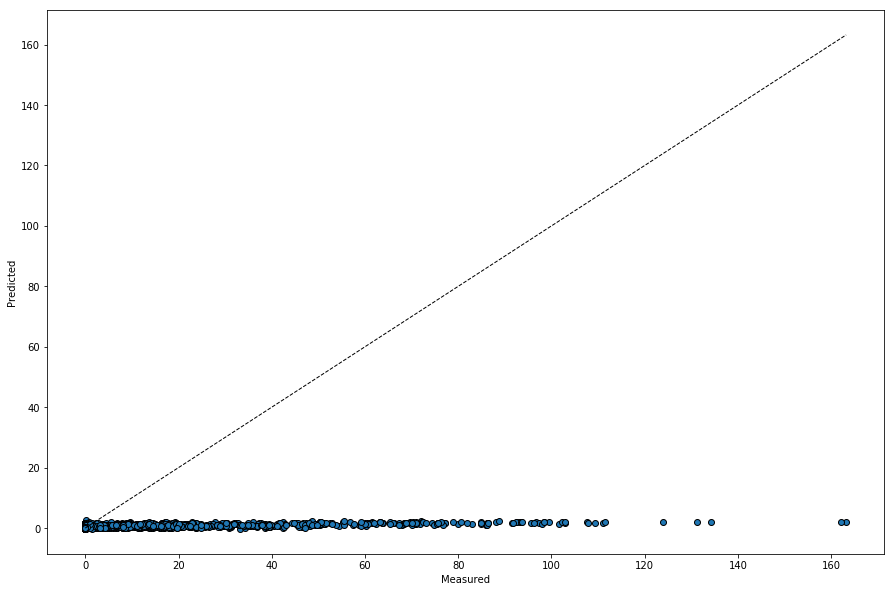

In [39]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()